In [1]:
stations_file = "model_results/stations_cold.csv.gz"
start_date = "2014-01-01"
variables = ["DO","NO3","T","Alg1"]

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

Read all the stations data

In [2]:
df = pd.read_csv(stations_file, compression="gzip")
df.head()

,Time,Node,Layer,depth(m),DO,NO3,NH4,Alg1,Alg2,LDOC,...,POC23,PON21,PON22,PON23,POP21,POP22,POP23,POS2,H1,BEN_STR
0,0.000463,6151,1,0.323122,7.99999,0.43,0.002,0.012996,0.012998,0.499999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000463,6151,2,1.237050,7.99999,0.43,0.002,0.013000,0.013000,0.499999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.000463,6151,3,2.592920,7.99999,0.43,0.002,0.013000,0.013000,0.499999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.000463,6151,4,4.263970,7.99999,0.43,0.002,0.013000,0.013000,0.499999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.000463,6151,5,6.197590,7.99999,0.43,0.002,0.013000,0.013000,0.499999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Assemble the MultiIndex so we can index results by time, node, and layer

In [3]:
mi = pd.MultiIndex.from_frame(df[["Time","Node","Layer"]])
del df['Time']
del df['Node']
del df['Layer']
df.set_index(mi, inplace=True)
df.head()

depth(m)       DO   NO3    NH4      Alg1      Alg2  \
Time     Node Layer                                                       
0.000463 6151 1      0.323122  7.99999  0.43  0.002  0.012996  0.012998   
              2      1.237050  7.99999  0.43  0.002  0.013000  0.013000   
              3      2.592920  7.99999  0.43  0.002  0.013000  0.013000   
              4      4.263970  7.99999  0.43  0.002  0.013000  0.013000   
              5      6.197590  7.99999  0.43  0.002  0.013000  0.013000   

                         LDOC  RDOC      LPOC      RPOC  ...  POC23  PON21  \
Time     Node Layer                                      ...                 
0.000463 6151 1      0.499999   0.5  0.099641  0.099642  ...    NaN    NaN   
              2      0.499999   0.5  0.099999  0.100000  ...    NaN    NaN   
              3      0.499999   0.5  0.099999  0.100000  ...    NaN    NaN   
              4      0.499999   0.5  0.099999  0.100000  ...    NaN    NaN   
              5      0.499999   0.5  0.099999  0.100000  ...    NaN    NaN   

                     PON22  PON23  POP21  POP22  POP23  POS2  H1  BEN_STR  
Time     Node Layer                                                        
0.000463 6151 1        NaN    NaN    NaN    NaN    NaN   NaN NaN      NaN  
              2        NaN    NaN    NaN    NaN    NaN   NaN NaN      NaN  
              3        NaN    NaN    NaN    NaN    NaN   NaN NaN      NaN  
              4        NaN    NaN    NaN    NaN    NaN   NaN NaN      NaN  
              5        NaN    NaN    NaN    NaN    NaN   NaN NaN      NaN  

[5 rows x 104 columns]

Build a DatetimeIndex for formatting X-axis labels

In [4]:
times = mi.levels[0]
dates = pd.Timestamp(start_date) + pd.to_timedelta(times, 'd')
dates[:10]

DatetimeIndex(['2014-01-01 00:00:40.000003200',
                         '2014-01-01 06:00:00',
                         '2014-01-01 12:00:00',
                         '2014-01-01 18:00:00',
                         '2014-01-02 00:00:00',
                         '2014-01-02 06:00:00',
                         '2014-01-02 12:00:00',
                         '2014-01-02 18:00:00',
                         '2014-01-03 00:00:00',
                         '2014-01-03 06:00:00'],
              dtype='datetime64[ns]', name='Time', freq=None)

# Timeseries Plots of a Single Variable, Single Station

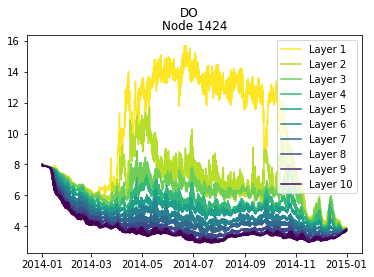

In [5]:
# Make a cycler from a colormap for the depth layers
cyc = plt.cycler("color", plt.cm.viridis_r(np.linspace(0, 1, mi.levshape[2])))

def ts_plot_station(var, station, data=None, ax=None):
    build_legend = (ax is None)
    if ax is None:
        fig, ax = plt.subplots()
    if data is None:
        data = df.loc[:, station, :][var]
    ax.set_prop_cycle(cyc)
    lines = []
    for l,lgroup in data.groupby(level=1):
        times = lgroup.index.levels[0]
        lines.append(ax.plot(dates, lgroup, label='Layer {0}'.format(l))[0])
    ax.set_title("Node {0}".format(station))
    if build_legend:
        ax.legend()
        fig.suptitle(var)
    return lines

# How to make a plot for a single variable at a single station
ts_plot_station("DO", 1424)

# Timeseries Plots of All Variables, All Stations

In [6]:
plot_columns = 3

def ts_plot_variable(var):
    nstations = mi.levshape[1]
    plot_rows = int(np.ceil(nstations / plot_columns))
    fig, axs = plt.subplots(plot_rows, plot_columns, figsize=(12,18))
    for ax,(n,ngroup) in zip(axs.flatten(), df[var].groupby(level=1)):
        lines = ts_plot_station(var, n, data=ngroup.loc[:,n,:], ax=ax)
        # The default x tick & label positions make the axis too crammed
        ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    fig.legend(lines, ["Layer {0}".format(n) for n in range(1, mi.levshape[2]+1)],
               loc="lower right")
    fig.suptitle(var)
    fig.tight_layout()

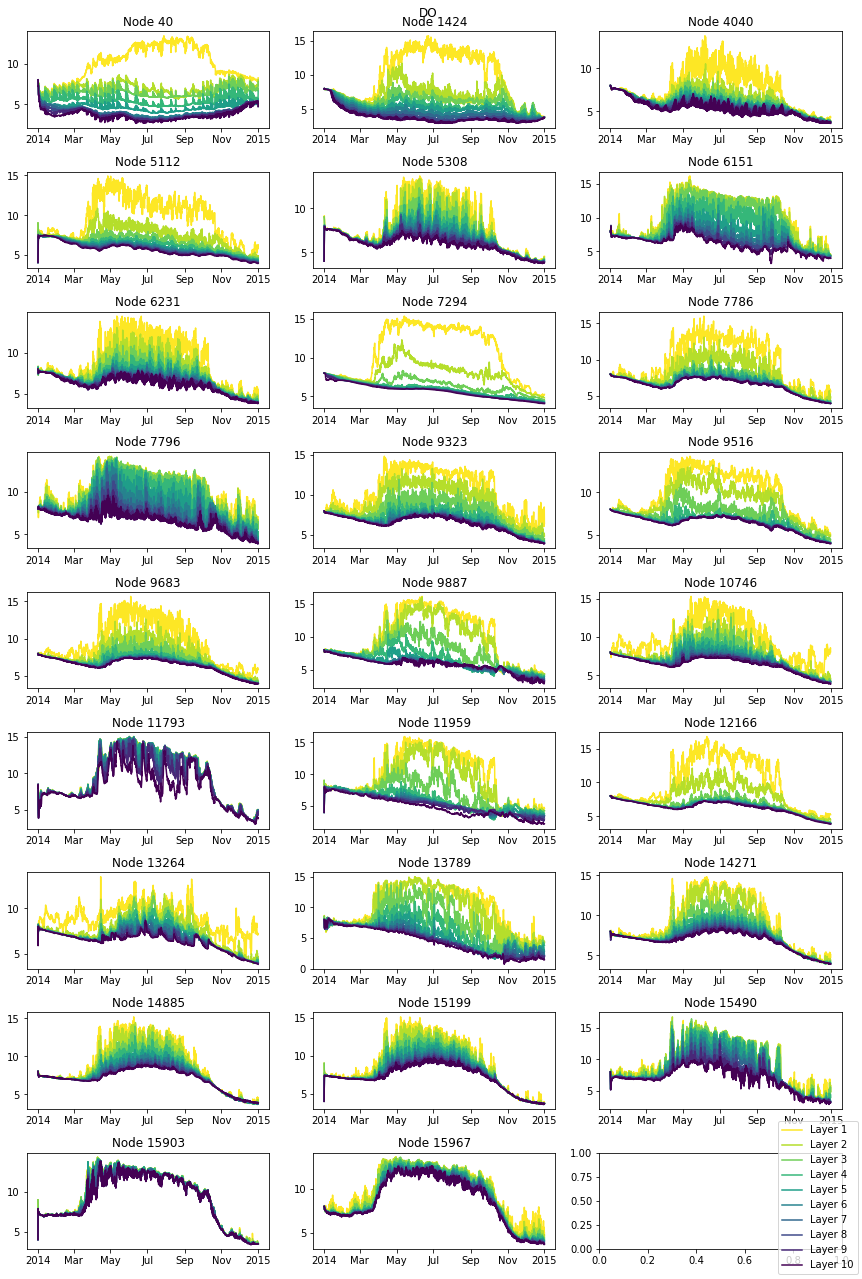

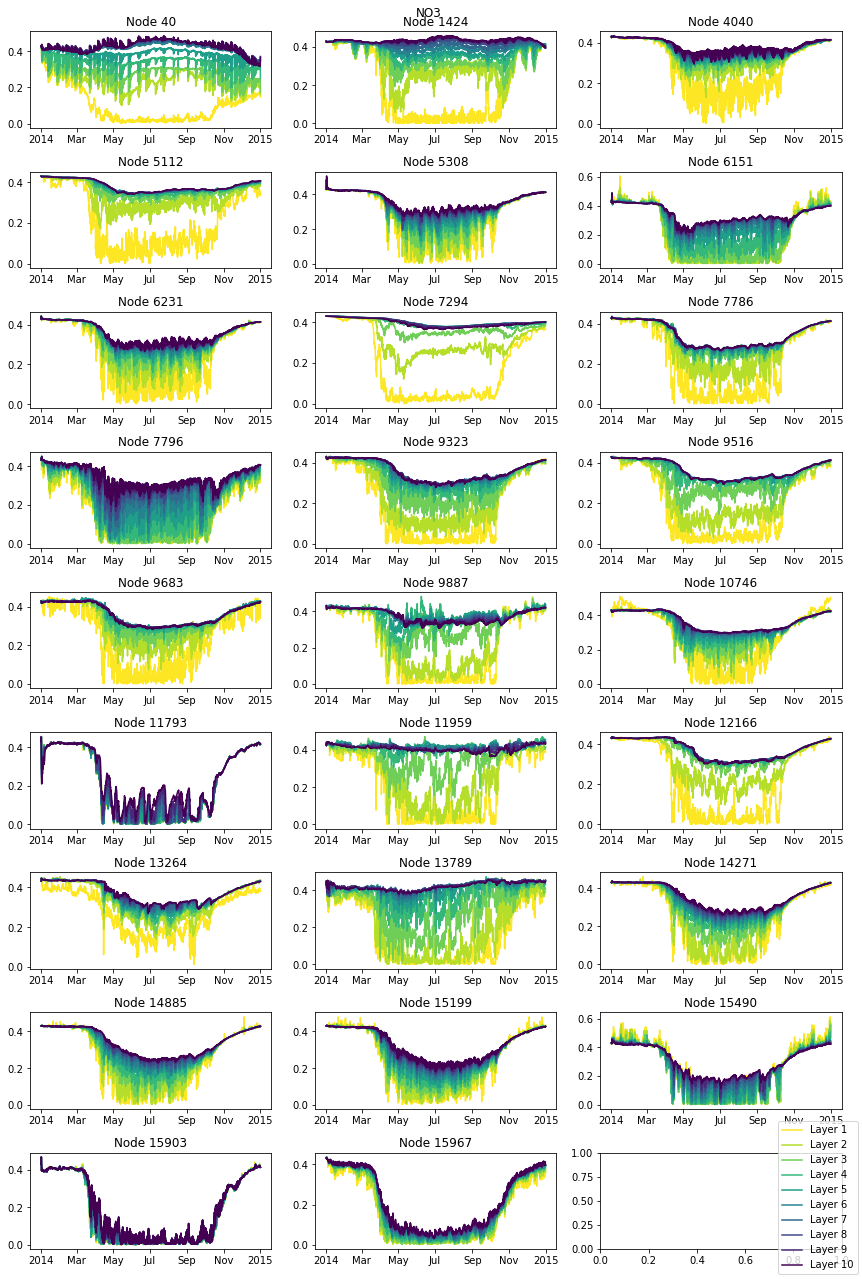

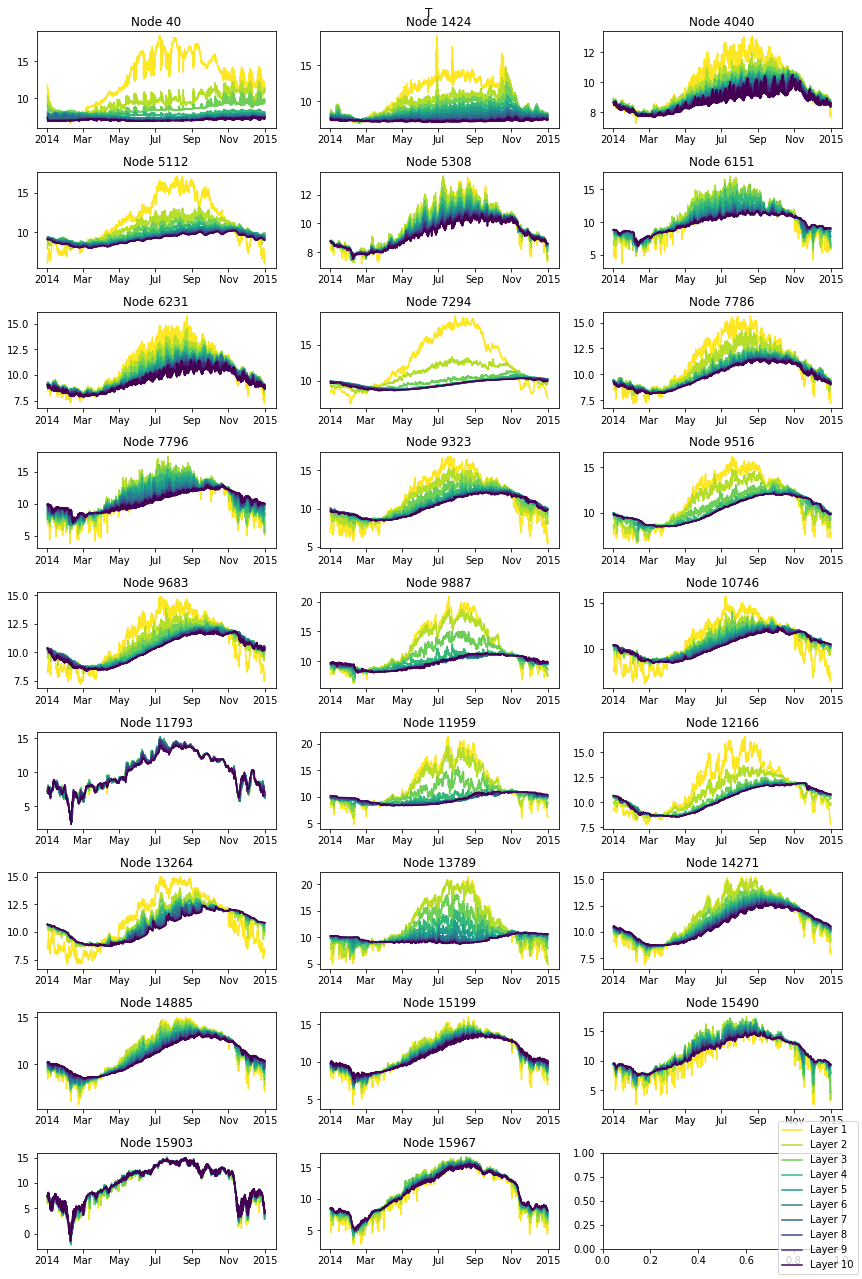

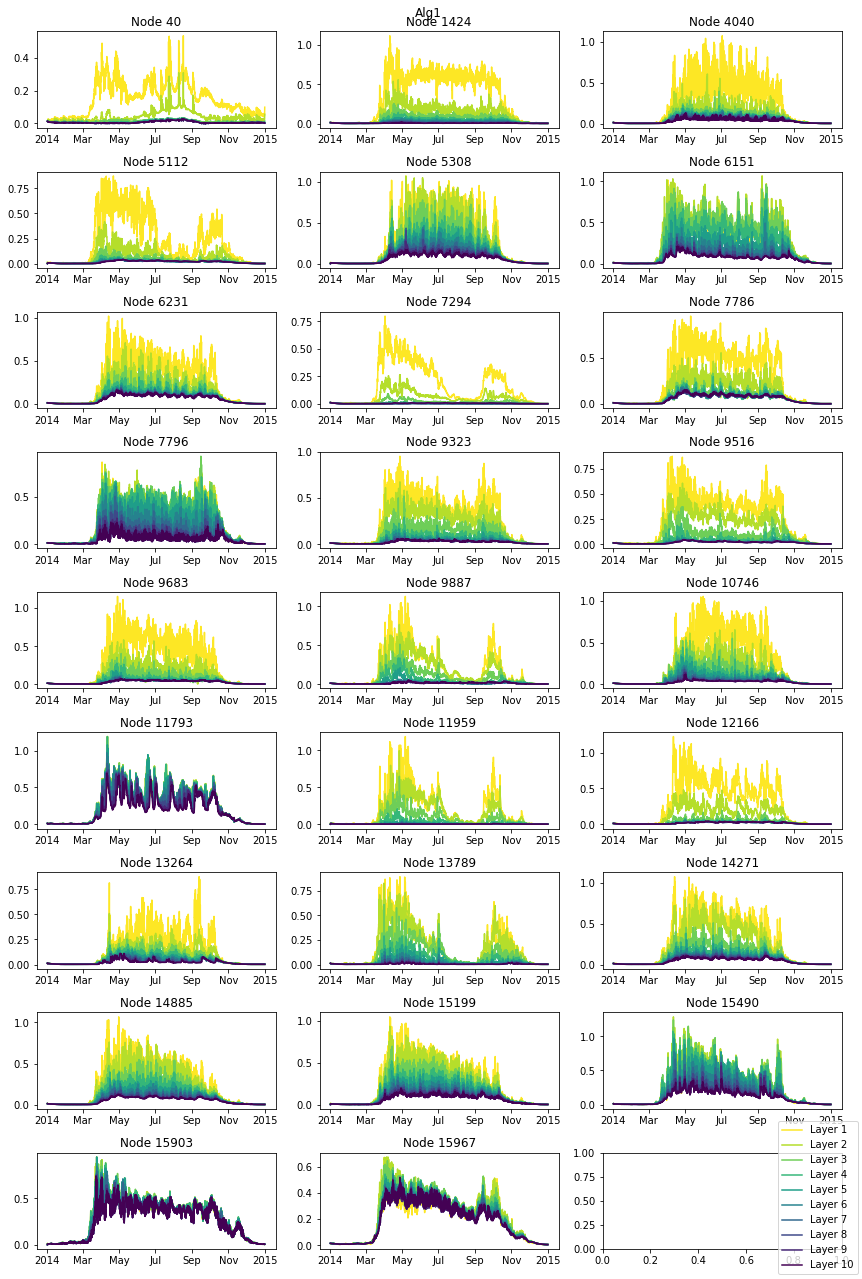

In [7]:
for v in variables:
    ts_plot_variable(v)